# Simple batch reactor

* Adiabatic, constant pressure
* Based on Cantera python example reactor1.py
* See the [Cantera website](http://www.cantera.org/docs/sphinx/html/cython/zerodim.html) for details

In [1]:
import cantera as ct
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

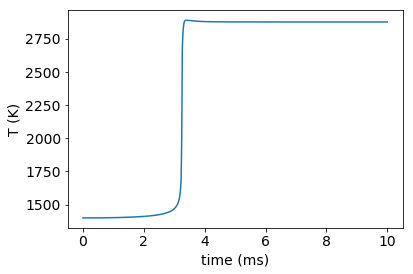

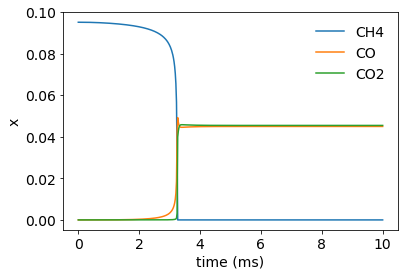

In [2]:
#------------------ user specifications

P        = 101325                  # Pa
T0       = 1400                    # K
X0       = "CH4:1, O2:2, N2:7.52"  # moles
trun     = 0.01                    # run time (s)
ntimes   = 500                     # number of times to save
spPlot   = ["CH4", 'CO', 'CO2']    # species to plot

#------------------ define the reactor gas and initial condition

gas  = ct.Solution("gri30.yaml")
gas.TPX  = T0,  P, X0              # this is the reactor initial condition

#------------------ define the reactor

rxr         = ct.IdealGasReactor(gas, volume=1)
rxrNet      = ct.ReactorNet([rxr])

#------------------ setup variables for results

isp    = [gas.species_index(k) for k in spPlot]
times  = np.linspace(0,trun,ntimes)
T      = np.zeros(ntimes)
xsp    = np.zeros((ntimes,len(spPlot)))

#------------------ run the reactor

for i, t in enumerate(times):
    
    rxrNet.advance(t)
    
    T[i] = rxr.thermo.T
    for k in range(len(spPlot)):
        xsp[i,k] = rxr.thermo.X[isp[k]]
    
#------------------ plot results

plt.rc('font', size=14)    

plt.plot(times*1000, T)
plt.xlabel('time (ms)')
plt.ylabel('T (K)');

plt.figure()
for i in range(len(spPlot)):
    plt.plot(times*1000,xsp[:,i], label=spPlot[i])
plt.legend(spPlot, frameon=False)
plt.xlabel('time (ms)')
plt.ylabel('x');


# CSTR reactor

* Constant volume, adiabatic CSTR



τ = 0.07590160355684827 (s)


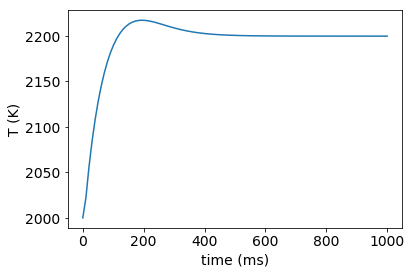

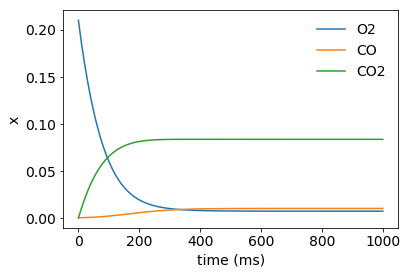

In [3]:
#                                                      ------     
# (Air Reservoir)  ----> (mass flow controller)  ----> |    |
#                                                      |CSTR| ----> (Valve) ----> (Environment Reservoir)
# (Fuel Reservoir) ----> (mass flow controller)  ----> |    |
#                                                      ------     
#------------------ user specifications

P        = 101325              # Pa
TairIn   = 300                 # K
TfuelIn  = 300                 # K
Tcstr0   = 2000                # K
Vcstr    = 1                   # m^3
mdotIn   = 2                   # kg/s total inlet flow rate
FA_ratio = 0.05795             # mass ratio: fuel/air
Xair     = "O2:0.21, N2:0.79"  # mole fractions
Xfuel    = "CH4:1"             # mole fractions
trun     = 1.0                 # run time (s)
ntimes   = 100                 # number of times to save
spPlot   = ['O2', 'CO', 'CO2'] # species to plot

#------------------ define the fuel, air, and cstr gases

fuel = ct.Solution("gri30.yaml")
air  = ct.Solution("gri30.yaml")
gas  = ct.Solution("gri30.yaml")

fuel.TPX = TfuelIn, P, Xfuel
air.TPX  = TairIn,  P, Xair
gas.TPX  = Tcstr0,  P, Xair         # this is the reactor initial condition

#------------------ define the streams and the reactor

inletAir     = ct.Reservoir(air)
inletFuel    = ct.Reservoir(fuel)
environment  = ct.Reservoir(air)

cstr         = ct.IdealGasReactor(gas, volume=Vcstr)

mdotAir      = mdotIn/(1+FA_ratio)
mdotFuel     = mdotIn-mdotAir

mfcAir       = ct.MassFlowController(inletAir,  cstr, mdot=mdotAir)
mfcFuel      = ct.MassFlowController(inletFuel, cstr, mdot=mdotFuel)
valveExhaust = ct.Valve(cstr, environment, K=1000)

#------------------ add a wall for optional expansion and/or heat transfer
# A is area (m2)
# K is a volume expansion rate coefficient: dV/dt = K*(P_1-P_2)
# U is an overall heat transfer coefficient. 

wall = ct.Wall(cstr, environment, A=1, K=0, U=0)

#------------------ define the reactor network

rxrNet       = ct.ReactorNet([cstr])

#------------------ setup variables for results

isp    = [gas.species_index(k) for k in spPlot]
times  = np.linspace(0,trun,ntimes)
T = np.zeros(ntimes)
nsp = len(spPlot)
xsp = np.zeros((ntimes,nsp))

#------------------ run the reactor

for i, t in enumerate(times):
    
    rxrNet.advance(t)
    
    T[i]     = cstr.thermo.T
    for k in range(len(spPlot)):
        xsp[i,k] = cstr.thermo.X[isp[k]]
    
#-----------------------

plt.rc('font', size=14)    

plt.plot(times*1000, T)
plt.xlabel('time (ms)')
plt.ylabel('T (K)');

plt.figure()
for i in range(nsp):
    plt.plot(times*1000,xsp[:,i], label=spPlot[i])
plt.legend(spPlot, frameon=False)
plt.xlabel('time (ms)')
plt.ylabel('x');

#-----------------------

tau = cstr.thermo.density*Vcstr/mdotIn
print("τ =", tau, "(s)")

# Diesel engine
* From [Cantera ic_engine.py example](http://www.cantera.org/docs/sphinx/html/cython/examples/reactors_ic_engine.html)

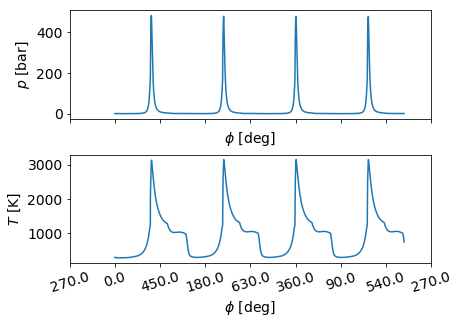

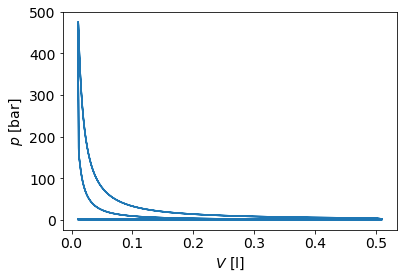

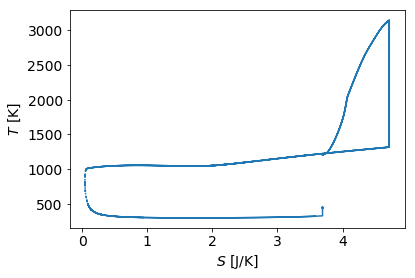

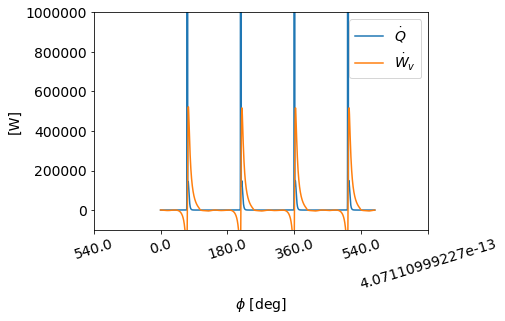

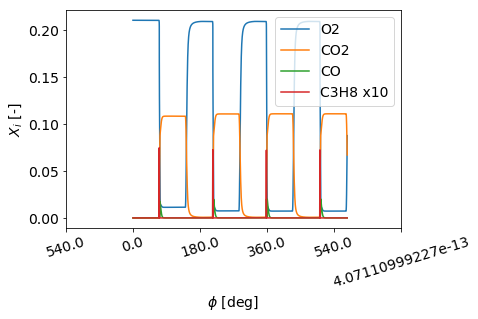

In [4]:
##################### user specifications

engine_rps = 3000. / 60.  # engine speed (1/s) revolutions per second
V_cylinder = .5e-3        # displaced volume (m^3)
CR         = 50.          # compression ratio 
d_piston   = 0.083        # piston diameter (m)

#---------- turbocharger inlet (air inlet) 
T_inlet = 300.            # (K)
p_inlet = 1.3e5           # (Pa)
X_inlet = 'O2:1, N2:3.76'

#---------- outlet pressure
p_outlet = 1.2e5  # Pa

#---------- fuel properties (gaseous!)
T_injector = 300.         # (K)
p_injector = 1600e5       # (Pa)
X_injector = 'C3H8:1'

#---------- ambient properties
T_ambient = 300.          # (K)
p_ambient = 1e5           # (Pa)
X_ambient = 'O2:1, N2:3.76'

#---------- Inlet valve friction coefficient, open and close timings
inlet_valve_coeff  = 1.e-6
inlet_open         = -18 * (np.pi/180)     # degrees --> radians
inlet_close        = 198 * (np.pi/180)     # degrees --> radians

#---------- Outlet valve friction coefficient, open and close timings
outlet_valve_coeff = 1.e-6
outlet_open        = 522 * (np.pi/180)     # degrees --> radians
outlet_close       = 18  * (np.pi/180)     # degrees --> radians

#---------- Fuel mass, injector open and close timings
injector_open      = 350  * (np.pi/180)
injector_close     = 365  * (np.pi/180)
injector_mass      = 3.2e-5  # kg
injector_t_open    = (injector_close - injector_open)/2./np.pi/engine_rps

#---------- Simulation time and resolution
sim_n_revolutions = 8 
nt                = 100000                 # number of timesteps

##################### set reactor and inlet, fuel, outlet, and ambient reservoirs

gas = ct.Solution('gri30.yaml')                    # set gas object
         
gas.TPX     = T_inlet, p_inlet, X_inlet           # set initial state
cylinder    = ct.IdealGasReactor(gas)             # set reactor 
            
gas.TPX     = T_inlet, p_inlet, X_inlet           # define inlet state
inlet       = ct.Reservoir(gas)                   # set inlet reservoir

gas.TPX     = T_injector, p_injector, X_injector  # define injector state (gaseous)
injector    = ct.Reservoir(gas)                   # set injector reservoir

gas.TPX     = T_ambient, p_outlet, X_ambient      # set outlet pressure (T, X don't matter)
outlet      = ct.Reservoir(gas)                   # set outlet reservoir

gas.TPX     = T_ambient, p_ambient, X_ambient     # set ambient pressure (T, X don't matter)
ambient_air = ct.Reservoir(gas)                   # set ambient reservoir

##################### set connecting devices

inlet_valve  = ct.Valve(inlet, cylinder)
injector_mfc = ct.MassFlowController(injector, cylinder)
outlet_valve = ct.Valve(cylinder, outlet)
piston       = ct.Wall(ambient_air, cylinder)

##################### convert time to crank angle

def crank_angle(t):
    return np.remainder(2 * np.pi * engine_rps * t, 4 * np.pi)

##################### set up IC engine parameters

A_piston        = np.pi/4*d_piston**2
L_stroke        = V_cylinder / A_piston
cylinder.volume = V_cylinder / (CR - 1.)
piston.area     = A_piston

def piston_speed(t):
    return -L_stroke/2 *2*np.pi*engine_rps*np.sin(crank_angle(t))

piston.set_velocity(piston_speed)

##################### create a reactor network containing the cylinder

rxrNet = ct.ReactorNet([cylinder])

##################### set output variables

states            = ct.SolutionArray(cylinder.thermo)
t_sim             = sim_n_revolutions / engine_rps
times             = (np.arange(nt) + 1) / nt * t_sim
V                 = np.zeros_like(times)
m                 = np.zeros_like(times)
test              = np.zeros_like(times)
mdot_in           = np.zeros_like(times)
mdot_out          = np.zeros_like(times)
d_W_v_d_t         = np.zeros_like(times)
heat_release_rate = np.zeros_like(times)

##################### set parameters for the automatic time step refinement

n_last_refinement = -np.inf  # for initialization only
n_wait_coarsening = 10

##################### run the engine

for n1, t in enumerate(times):
    
    #---------- define opening and closing of valves and injector
    
    if (np.mod(crank_angle(t) - inlet_open, 4*np.pi) <
            np.mod(inlet_close - inlet_open, 4*np.pi)):
        inlet_valve.set_valve_coeff(inlet_valve_coeff)
        test[n1] = 1
    else:
        inlet_valve.set_valve_coeff(0)
    if (np.mod(crank_angle(t) - outlet_open, 4*np.pi) <
            np.mod(outlet_close - outlet_open, 4*np.pi)):
        outlet_valve.set_valve_coeff(outlet_valve_coeff)
    else:
        outlet_valve.set_valve_coeff(0)
    if (np.mod(crank_angle(t) - injector_open, 4*np.pi) <
            np.mod(injector_close - injector_open, 4*np.pi)):
        injector_mfc.set_mass_flow_rate(injector_mass / injector_t_open)
    else:
        injector_mfc.set_mass_flow_rate(0)

    #---------- perform time integration, refine time step if necessary
    
    for n2 in range(4):
        if n2 is 4:
            raise 'Error: Refinement limit reached'
        try:
            rxrNet.advance(t)
        except Exception:
            rxrNet.set_max_time_step(1e-6 * 10**-n2)
            n_last_refinement = n1
            
    #---------- coarsen time step if too long ago
    
    if n1 - n_last_refinement is n_wait_coarsening:
        rxrNet.set_max_time_step(1e-5)

    #---------- write output data
    
    states.append(cylinder.thermo.state)
    V[n1]                 = cylinder.volume
    m[n1]                 = cylinder.mass
    mdot_in[n1]           = inlet_valve.mdot(0)
    mdot_out[n1]          = outlet_valve.mdot(0)
    d_W_v_d_t[n1]         = - (cylinder.thermo.P - ambient_air.thermo.P)*A_piston*piston_speed(t)
    heat_release_rate[n1] = -cylinder.volume*ct.gas_constant*cylinder.T * \
                             np.sum(gas.standard_enthalpies_RT*cylinder.thermo.net_production_rates, 0)

##################### plot results

#---------- pressure and temperature

plt.figure()
plt.clf()
plt.subplot(211)
plt.tight_layout()
plt.plot(times, states.P / 1.e5)
plt.ylabel('$p$ [bar]')
plt.xlabel('$\phi$ [deg]')
plt.xticks(plt.xticks()[0], [])
plt.subplot(212)
plt.plot(times, states.T)
plt.ylabel('$T$ [K]')
plt.xlabel('$\phi$ [deg]')
plt.xticks(plt.xticks()[0], crank_angle(plt.xticks()[0]) * 180/np.pi, rotation=17)

#---------- p-V diagram

plt.figure()
plt.clf()
plt.plot(V[times > 0.04] * 1000, states.P[times > 0.04] / 1.e5)
plt.xlabel('$V$ [l]')
plt.ylabel('$p$ [bar]')

#---------- T-S diagram

plt.figure()
plt.clf()
plt.plot(m[times > 0.04] * states.s[times > 0.04], states.T[times > 0.04])
plt.xlabel('$S$ [J/K]')
plt.ylabel('$T$ [K]')

#---------- heat of reaction and expansion work

plt.figure()
plt.clf()
plt.plot(times, heat_release_rate, label='$\dot{Q}$')
plt.plot(times, d_W_v_d_t, label='$\dot{W}_v$')
plt.ylim(-1e5, 1e6)
plt.legend(loc=0)
plt.ylabel('[W]')
plt.xlabel('$\phi$ [deg]')
plt.xticks(plt.xticks()[0], crank_angle(plt.xticks()[0]) * 180/np.pi, rotation=17)

#---------- gas composition

plt.figure()
plt.clf()
plt.plot(times, states('O2').X, label='O2')
plt.plot(times, states('CO2').X, label='CO2')
plt.plot(times, states('CO').X, label='CO')
plt.plot(times, states('C3H8').X * 10, label='C3H8 x10')
plt.legend(loc=0)
plt.ylabel('$X_i$ [-]')
plt.xlabel('$\phi$ [deg]')
plt.xticks(plt.xticks()[0], crank_angle(plt.xticks()[0]) * 180/np.pi, rotation=17);

##################### integral results
#
#from scipy.integrate import trapz
#
#Q           = trapz(heat_release_rate, times)
#W           = trapz(d_W_v_d_t, times)
#eta         = W / Q
#MW          = states.mean_molecular_weight
#CO_emission = trapz(MW * mdot_out * states('CO').X, times) / trapz(MW * mdot_out, times)
#
#print('Heat release rate per cylinder (estimate):\t' + format(Q / t_sim / 1000., ' 2.1f') + ' kW')
#print('Expansion power per cylinder (estimate):\t' + format(W / t_sim / 1000., ' 2.1f') + ' kW')
#print('Efficiency (estimate):\t\t\t' + format(eta * 100., ' 2.1f') + ' %')
#print('CO emission (estimate):\t\t' + format(CO_emission * 1.e6, ' 2.1f') + ' ppm')